# RealNVP Model in PyTorch

This notebook provides a simple implementation of a RealNVP flow model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.distributions import MultivariateNormal

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Create a Normalize the Two Moons Dataset



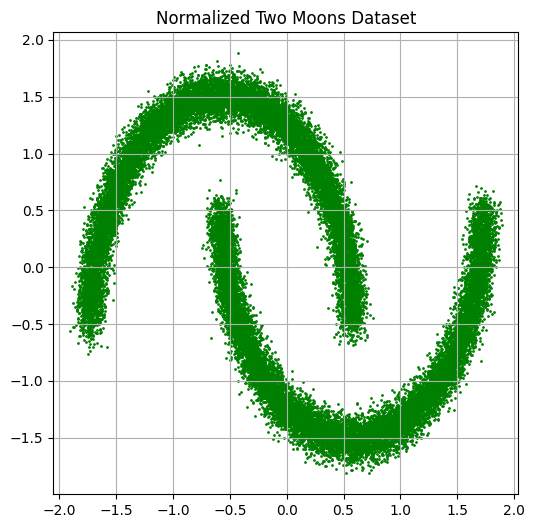

In [3]:
# Generate the two moons dataset
n_samples = 30000
data, _ = make_moons(n_samples=n_samples, noise=0.05)
data = data.astype(np.float32)

# Normalize the dataset
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Convert to PyTorch tensor and move to device
normalized_data = torch.tensor(normalized_data, dtype=torch.float32).to(device)

# Visualize the data
plt.figure(figsize=(6, 6))
plt.scatter(normalized_data[:, 0].cpu(), normalized_data[:, 1].cpu(), s=1, c='green')
plt.title("Normalized Two Moons Dataset")
plt.axis("equal")
plt.grid(True)
plt.show()

In [4]:
class CouplingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Scale output: initialized near zero with tanh for stability
        self.scale = nn.Linear(hidden_dim, input_dim)
        self.translate = nn.Linear(hidden_dim, input_dim)

        # Apply Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        h = self.net(x)
        s = torch.tanh(self.scale(h)) * 2.0  # bounded scaling
        t = self.translate(h)
        return s, t

In [5]:
class RealNVP(nn.Module):
    def __init__(self, input_dim=2, num_coupling_layers=6):
        super().__init__()
        self.input_dim = input_dim
        self.num_coupling_layers = num_coupling_layers

        # Prior distribution in latent space
        self.prior = torch.distributions.MultivariateNormal(
            torch.zeros(input_dim).to(device),
            torch.eye(input_dim).to(device)
        )

        # Alternating binary masks, e.g., [0,1], [1,0], ...
        self.masks = torch.tensor(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2),
            dtype=torch.float32
        ).to(device)

        # Create coupling layers
        self.coupling_layers = nn.ModuleList([
            CouplingMLP(input_dim=input_dim) for _ in range(num_coupling_layers)
        ])

    def forward(self, x, reverse=False):
        """
        If reverse=False: maps data → latent (x → z)
        If reverse=True:  maps latent → data (z → x)
        """
        log_det = torch.zeros(x.shape[0], device=x.device)
        direction = -1 if not reverse else 1
        layers = range(self.num_coupling_layers)[::direction]

        for i in layers:
            mask = self.masks[i]
            x_masked = x * mask
            s, t = self.coupling_layers[i](x_masked)

            s = s * (1 - mask)
            t = t * (1 - mask)

            if reverse:
                x = (x - t) * torch.exp(-s) * (1 - mask) + x_masked
            else:
                x = (x * torch.exp(s) + t) * (1 - mask) + x_masked
                log_det += torch.sum(s, dim=1)

        return x, log_det

    def log_prob(self, x):
        """
        Log probability of input x under the model.
        """
        z, log_det = self.forward(x, reverse=False)
        log_prob_z = self.prior.log_prob(z)
        return log_prob_z + log_det

    def loss(self, x):
        """
        Negative log-likelihood loss.
        """
        return -self.log_prob(x).mean()

In [6]:
batch_size = 256
epochs = 100
learning_rate = 1e-4

In [7]:
dataset = TensorDataset(normalized_data)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
model = RealNVP(input_dim=2, num_coupling_layers=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    model.train()

    for batch in train_loader:
        x = batch[0].to(device)

        optimizer.zero_grad()
        loss = model.loss(x)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [10/100], Loss: 1.3349
Epoch [20/100], Loss: 1.2672
Epoch [30/100], Loss: 1.2408
Epoch [40/100], Loss: 1.2296
Epoch [50/100], Loss: 1.2191
Epoch [60/100], Loss: 1.2145
Epoch [70/100], Loss: 1.1950
Epoch [80/100], Loss: 1.1911
Epoch [90/100], Loss: 1.1978
Epoch [100/100], Loss: 1.1867


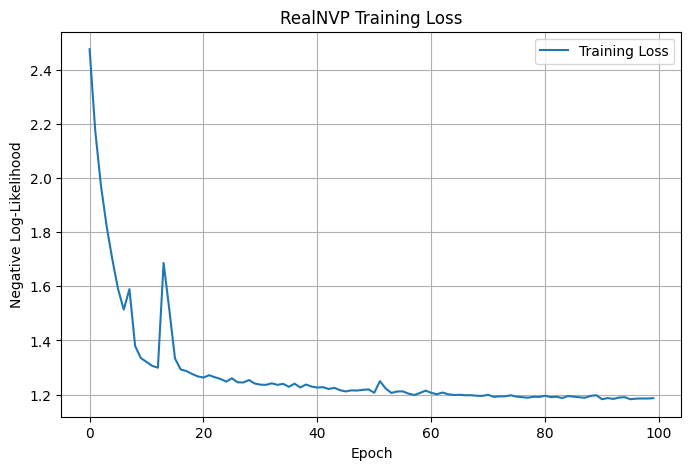

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("RealNVP Training Loss")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
model.eval()
with torch.no_grad():
    z, _ = model(normalized_data, reverse=False)

In [12]:
with torch.no_grad():
    z_samples = model.prior.sample((3000,))
    x_samples, _ = model(z_samples, reverse=True)

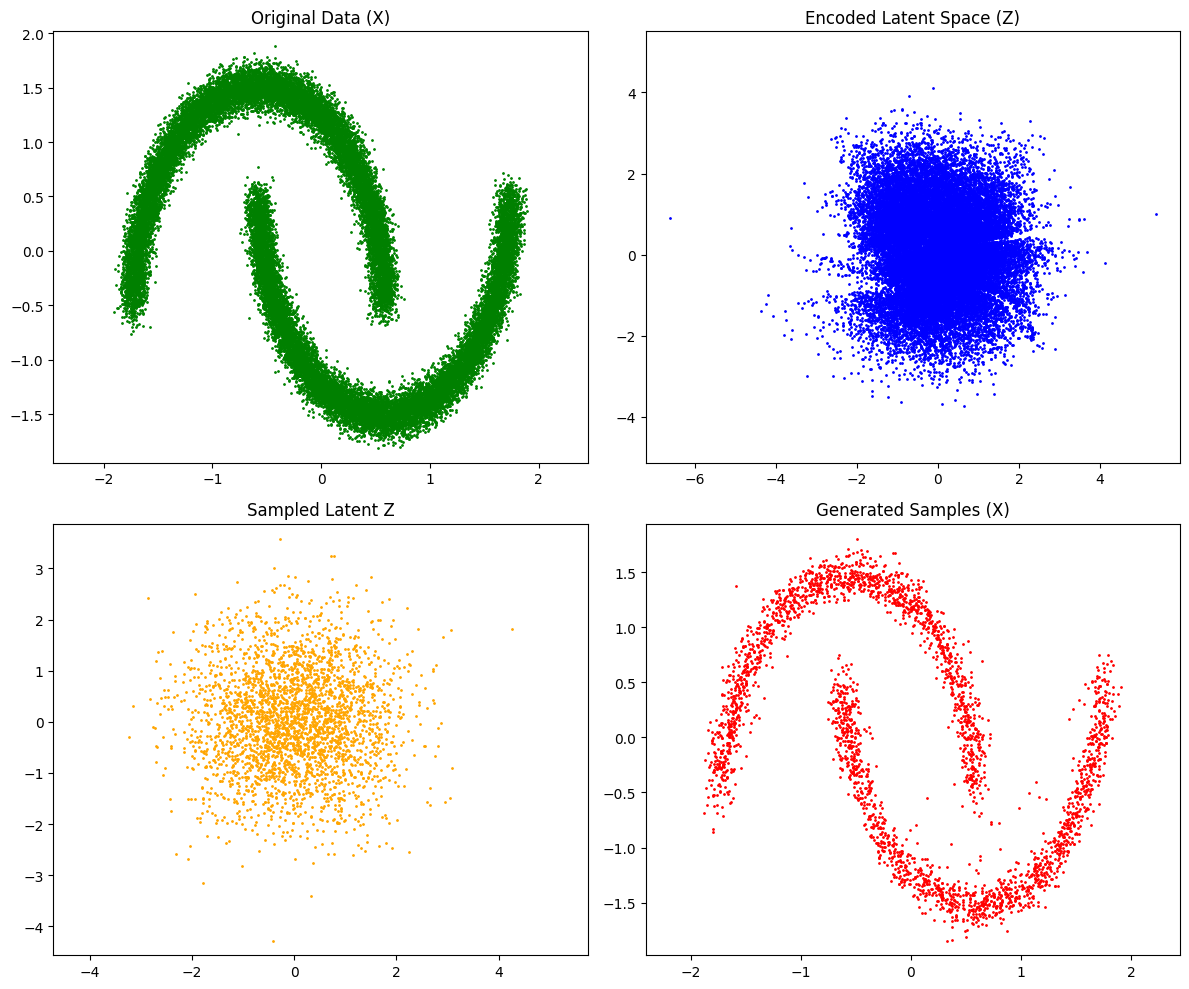

In [13]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original data
axes[0, 0].scatter(normalized_data[:, 0].cpu(), normalized_data[:, 1].cpu(), s=1, c='green')
axes[0, 0].set_title("Original Data (X)")
axes[0, 0].axis("equal")

# Latent representation of data
axes[0, 1].scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=1, c='blue')
axes[0, 1].set_title("Encoded Latent Space (Z)")
axes[0, 1].axis("equal")

# Random latent samples
axes[1, 0].scatter(z_samples[:, 0].cpu(), z_samples[:, 1].cpu(), s=1, c='orange')
axes[1, 0].set_title("Sampled Latent Z")
axes[1, 0].axis("equal")

# Transformed back to data
axes[1, 1].scatter(x_samples[:, 0].cpu(), x_samples[:, 1].cpu(), s=1, c='red')
axes[1, 1].set_title("Generated Samples (X)")
axes[1, 1].axis("equal")

plt.tight_layout()
plt.show()